In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL

but Gdown can't. Please check connections and permissions.

In [ ]:
def load_video(path:str) -> List[float]:
    #print(path)

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    #print(path)
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = tf.convert_to_tensor(path).numpy().decode('utf-8')
    from pathlib import Path
    fn=Path(path).stem.split('\\')[-1]
    video_path = os.path.join('data','s1',f'{fn}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{fn}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '.\\data\\s1\\bbal6n.mpg'
from pathlib import Path
print(Path(test_path).stem.split('\\')[-1])

bbal6n


In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

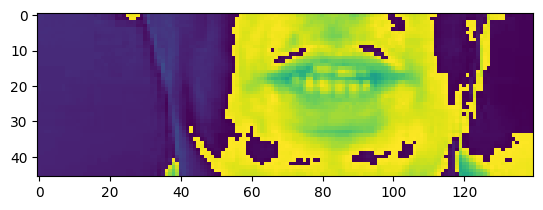

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
print("Frames shape:", frames.shape)
print("Alignments shape:", alignments.shape)

Frames shape: (75, 46, 140, 1)
Alignments shape: (21,)


In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    #print(path)
    return result

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#print(data)
# Added for split
train = data.take(250)
test = data.skip(250)

In [ ]:
data.as_numpy_iterator().next()

(array([[[[[1.3637602 ],
           [1.3637602 ],
           [1.3637602 ],
           ...,
           [0.03788223],
           [0.03788223],
           [0.03788223]],
 
          [[1.3637602 ],
           [1.3637602 ],
           [1.3637602 ],
           ...,
           [0.03788223],
           [0.03788223],
           [0.03788223]],
 
          [[1.3637602 ],
           [1.3637602 ],
           [1.3637602 ],
           ...,
           [0.18941115],
           [0.11364669],
           [0.11364669]],
 
          ...,
 
          [[0.98493797],
           [0.9470557 ],
           [0.9470557 ],
           ...,
           [9.546322  ],
           [9.470557  ],
           [9.470557  ]],
 
          [[0.9470557 ],
           [0.9470557 ],
           [0.9470557 ],
           ...,
           [9.394793  ],
           [9.432675  ],
           [9.432675  ]],
 
          [[0.9470557 ],
           [0.9470557 ],
           [0.9470557 ],
           ...,
           [9.432675  ],
           [9.508439  

In [ ]:
len(test)
len(train)

250

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
alignments

array([[12,  1, 25, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39, 13,
        39, 15, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39, 18,  5,  4, 39,  2, 25, 39, 20, 39, 20,  8, 18,
         5,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.4659775 ],
          [ 1.5035667 ],
          [ 1.0900859 ],
          ...,
          [ 0.41348085],
          [ 0.33830252],
          [ 0.33830252]],

         [[ 1.3532101 ],
          [ 1.3532101 ],
          [ 1.0900859 ],
          ...,
          [ 0.41348085],
          [ 0.33830252],
          [ 0.33830252]],

         [[ 1.3907992 ],
          [ 1.4283884 ],
          [ 1.3156209 ],
          ...,
          [ 0.3758917 ],
          [ 0.33830252],
          [ 0.33830252]],

         ...,

         [[ 1.0149075 ],
          [ 1.0149075 ],
          [ 1.0149075 ],
          ...,
          [ 0.07517833],
          [ 0.07517833],
          [ 0.07517833]],

         [[ 1.0149075 ],
          [ 1.0149075 ],
          [ 1.0149075 ],
          ...,
          [ 0.07517833],
          [ 0.07517833],
          [ 0.07517833]],

         [[ 1.0149075 ],
          [ 1.0149075 ],
          [ 1.0149075 ],
          ...,
          [ 0.07517833],
          [ 0.07517833],
          

In [ ]:
val[0][1]

array([[[[ 0.82553643],
         [ 1.3365828 ],
         [ 1.6117616 ],
         ...,
         [ 0.23586755],
         [ 0.23586755],
         [ 0.23586755]],

        [[ 0.11793377],
         [ 0.82553643],
         [ 1.218649  ],
         ...,
         [ 0.23586755],
         [ 0.23586755],
         [ 0.23586755]],

        [[ 0.9434702 ],
         [ 0.98278147],
         [ 0.86484766],
         ...,
         [ 0.31449008],
         [ 0.31449008],
         [ 0.31449008]],

        ...,

        [[ 1.1400265 ],
         [ 1.1400265 ],
         [ 1.1400265 ],
         ...,
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 1.1007153 ],
         [ 1.1007153 ],
         [ 1.1007153 ],
         ...,
         [10.024371  ],
         [10.024371  ],
         [10.024371  ]],

        [[ 1.1007153 ],
         [ 1.1007153 ],
         [ 1.1007153 ],
         ...,
         [10.024371  ],
         [10.024371  ],
         [10.024371  ]]],


       [[[ 0.90415895],


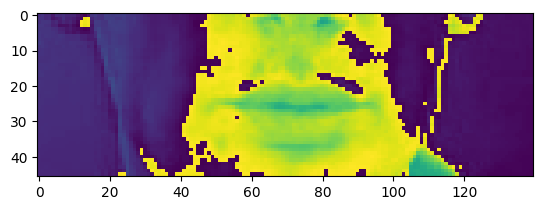

In [ ]:
#imageio.mimsave('./animation.gif', val[0][1],format='GIF', fps=10)
plt.imshow(val[0][0][45])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with h seven soon'>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 16s 16s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjj9999999999999jjjjjjjjjj9999999999jjjjjj999999999999999999999999999v'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'jjjjjjjj9999999999999jjjjjjjjjj9999999999jjjjjj999999999999999999999999999v'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):#Connectionist Temporal Classification
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
       self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/50
  4/250 [..............................] - ETA: 4:02:42 - loss: 189.6233

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save("/content/drive/MyDrive/lipReading/lipreadmodel.hdf5")